In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r'C:\Users\DAI.STUDENTSDC\Desktop\Machine Learning\Data\Data Sets\nutrient.csv', index_col=0)
df.head()

,energy,protein,fat,calcium,iron
Food_Item,,,,,
BEEF BRAISED,340,20,28,9,2.6
HAMBURGER,245,21,17,9,2.7
BEEF ROAST,420,15,39,7,2.0
BEEF STEAK,375,19,32,9,2.6
BEEF CANNED,180,22,10,17,3.7


<Figure size 400x400 with 0 Axes>

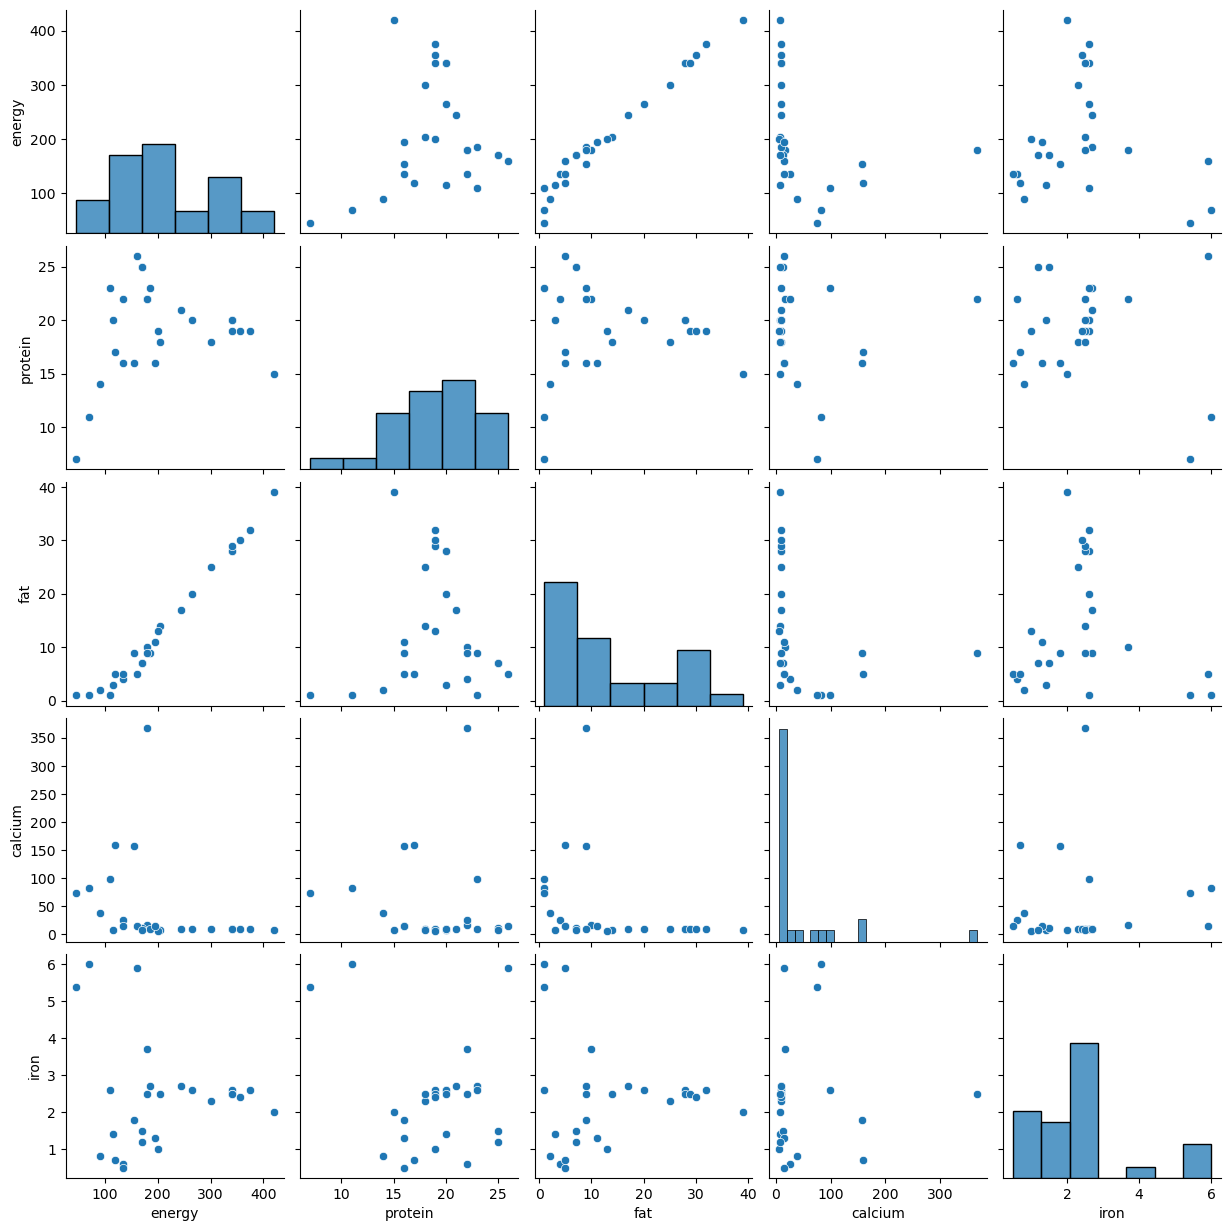

In [4]:
plt.figure(figsize=(4,4))
sns.pairplot(data=df, palette="Set2")
plt.show()

In [5]:
scalar = StandardScaler().set_output(transform='pandas')
df_scaled = scalar.fit_transform(df)

In [7]:
eps_range = [0.2,0.4,0.6,1]
mp_range = [2,3,4,5]
cnt = 0
a =[]

for i in eps_range:
    for j in mp_range:
        clust_DB = DBSCAN(eps=i, min_samples=j)
        clust_DB.fit(df_scaled.iloc[:,:5])
        
        if len(set(clust_DB.labels_)) > 2:
            """_summary_
            This condition is to avoid the case where the clustering is not
            possible due to the small number of data points because silhouette score
            cannot be calculated with only one cluster or less than 2 cluster.

            Here in clust_DB.labels_ we get  values like [-1,1,0,0,1,1,2,2....]
            Whete -1 is the outlier/noise
            1,2,3.. are the classified clusters
            """

            cnt = cnt + 1
            df_scaled['Clust'] = clust_DB.labels_

            # Adding temperature column which containes labelled of cluster or outlier.noise
            milk_scl_inliers = df_scaled[df_scaled['Clust']!=-1]
            
            sil_sc = silhouette_score(
                milk_scl_inliers.iloc[:,:-1],   # All the features except the Cluser label
                milk_scl_inliers.iloc[:,-1]     # Cluster label
            )
            
            a.append([cnt,i,j,sil_sc])
            print(i,j,sil_sc)
    
a = np.array(a)
pa = pd.DataFrame(a,columns=['Sr','eps','min_pt','sil'])

print("\nSilhouette Score:")
print(pa)

print("\nBest Paramters:")
best_params = pa[pa['sil'] == pa['sil'].max()]
print(best_params)

0.2 2 0.5710837307456915
0.4 2 0.9040570858308878
0.6 2 0.7752441663222646
1 2 0.43236957939711584
1 3 0.43147150560271585

Silhouette Score:
    Sr  eps  min_pt       sil
0  1.0  0.2     2.0  0.571084
1  2.0  0.4     2.0  0.904057
2  3.0  0.6     2.0  0.775244
3  4.0  1.0     2.0  0.432370
4  5.0  1.0     3.0  0.431472

Best Paramters:
    Sr  eps  min_pt       sil
1  2.0  0.4     2.0  0.904057


In [48]:
clust_DB = DBSCAN(
    eps=best_params['eps'][1],
    min_samples=int(best_params['min_pt'][1]),
    n_jobs=-1
)
clust_DB.fit(df_scaled.iloc[:, :5])

clust_df = df.copy()
clust_df['Clust'] = clust_DB.labels_

# Filter out noise points
milk_scl_inliers = clust_df[clust_df['Clust'] != -1]

# Ensure at least 2 clusters for valid Silhouette Score
if milk_scl_inliers['Clust'].nunique() > 1:
    sil_sc = silhouette_score(
        milk_scl_inliers.iloc[:, :-1],  # Exclude cluster labels
        milk_scl_inliers['Clust']
    )
    print("Silhouette Score:", sil_sc)
else:
    print("Not enough clusters for a valid Silhouette Score.")

Silhouette Score: 0.9251784799089636


In [49]:
milk_scl_inliers.groupby('Clust').mean()

,energy,protein,fat,calcium,iron
Clust,,,,,
0,350.0,19.4,29.4,9.0,2.52
1,170.0,25.0,7.0,9.5,1.35
